# Introduction to Optimization in GerryChain

This notebook walks through how to use the SingleMetricOptimizer class (as well as its Gingleator subclass) in order to perfrom heuristic optimization runs in GerryChain.

There are 3 heuristic optimization methods whose use is shown in this notebook:
* **Short Bursts**: chaining together small neutral explorers ([More reading about short bursts here](https://arxiv.org/abs/2011.02288))
* **Simulated Annealing**: vary the probability of accepting worse plans over time wrt a temperature parameter $\beta$.
* **Tilted runs**: accept worse plans with a fixed probability $p$

## When do we want to use Heuristic Optimization?

While sampling naively with GerryChain can give us an understanding of the neutral baseline for a state, there are often cases where we want to find plans with properties that are rare to encounter in a neutral run.  Many states have laws/guidelines that state that plans should be as compact as feasibly possible, maximize preservation of political boundaries and/or communities of interest, some even look to minimize double bunking of incumbents or seek proportionality/competitiveness in contests.  Heuristic optimization methods can be used to find example plans with these properties and to explore the trade-offs between them.

In [1]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
# from gerrychain.proposals import ReCom
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.tree import recursive_seed_part
# from gerrychain.updaters import Tally
from functools import partial
import pandas as pd
import json
import requests
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
response = json.loads(requests.get("https://people.csail.mit.edu/ddeford/BG/BG_05.json").text)
graph = Graph(json_graph.adjacency_graph(response))

In [3]:
POPCOL = "TOTPOP"
SEN_DISTS = 35
EPS = 0.02
TOTPOP = sum(graph.nodes()[n][POPCOL] for n in graph.nodes())

In [4]:
sddict = recursive_seed_part(graph, range(SEN_DISTS), TOTPOP/SEN_DISTS, POPCOL, EPS)

In [5]:
chain_updaters = {
   "population": updaters.Tally(POPCOL, alias="population"),
   "VAP": updaters.Tally("VAP"),
   "BVAP": updaters.Tally("BVAP")
}
part = Partition(graph, sddict, chain_updaters)

In [6]:
proposal = partial(
    proposals.recom,
    pop_col=POPCOL,
    pop_target=TOTPOP/SEN_DISTS,
    epsilon=EPS,
    node_repeats=1
)
cons = constraints.within_percent_of_ideal_population(part, EPS)

## Optimizing for Gingles Districts

Named for the Supreme Court case _Thornburg v. Gingles_, which created their precedent as one of the litmus tests in bringing forth a VRA court case, *Gingles' Districts* are districts that are 50% + 1 of a minority population subgroup (more colloquially called majority-minority districts).  It is common to seek plans with greater/maximal numbers of gingles districts to understand the landscape of the state space.

In [7]:
gingles = Gingleator(proposal, cons, part, 
                     minority_pop_col="BVAP", total_pop_col="VAP",
                     score_function=Gingleator.reward_partial_dist)

In [8]:
total_steps = 10000

In [9]:
max_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(gingles.short_bursts(10, 1000, with_progress_bar=True)):
    max_scores_sb[i] = gingles.best_score
    scores_sb[i] = gingles.score(part)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:06<00:00, 79.29it/s]


In [10]:
max_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)
for i, part in enumerate(gingles.simulated_annealing(total_steps, gingles.jumpcycle_beta_function(1000, 4000),
                                                     beta_magnitude=500, with_progress_bar=True)):
    max_scores_anneal[i] = gingles.best_score
    scores_anneal[i] = gingles.score(part)

100%|██████████| 10000/10000 [02:17<00:00, 72.75it/s]


In [11]:
max_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(gingles.tilted_run(total_steps, 0.125, with_progress_bar=True)):
    max_scores_tilt[i] = gingles.best_score
    scores_tilt[i] = gingles.score(part)

100%|██████████| 10000/10000 [02:22<00:00, 70.41it/s]


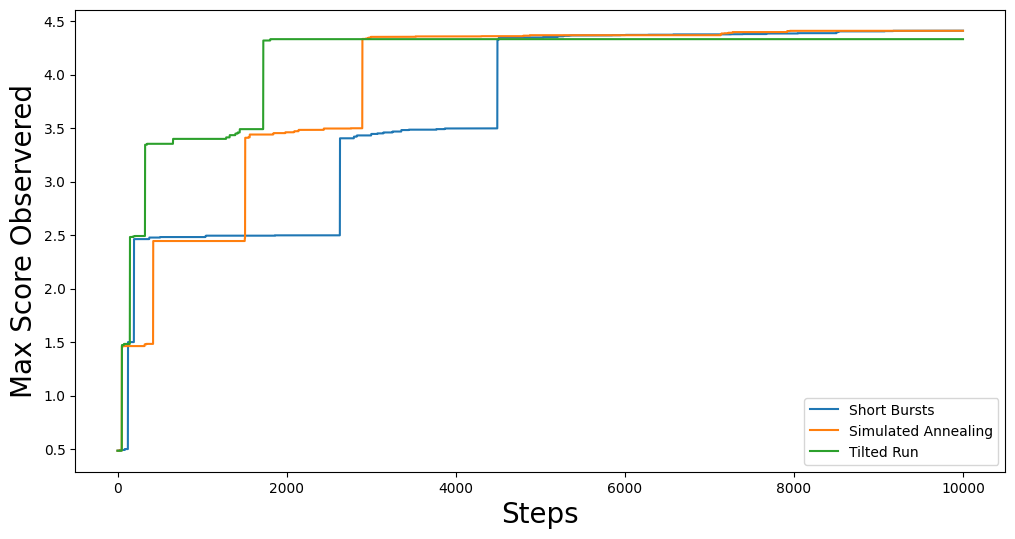

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(max_scores_sb, label="Short Bursts")
plt.plot(max_scores_anneal, label="Simulated Annealing")
plt.plot(max_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Max Score Observered", fontsize=20)
plt.legend()
plt.show()

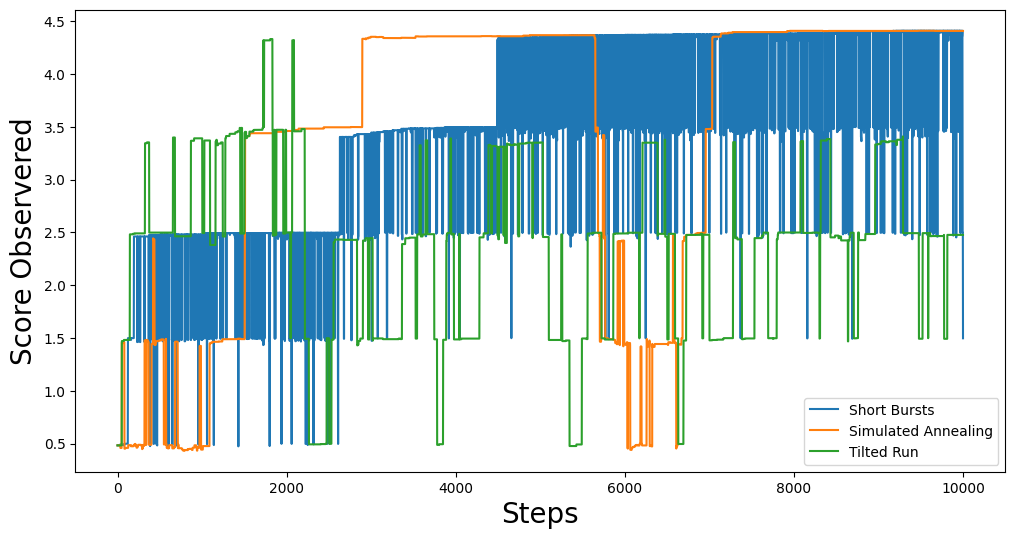

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(scores_sb, label="Short Bursts")
plt.plot(scores_anneal, label="Simulated Annealing")
plt.plot(scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Score Observered", fontsize=20)
plt.legend()
plt.show()

## Optimizing for Compactness

Another metric we may seek to optimize over is compactness.  Below we look at minimizing the number of cut edges in a plan.

In [14]:
num_cut_edges = lambda p: len(p["cut_edges"])
optimizer = SingleMetricOptimizer(proposal, cons, part, num_cut_edges, maximize=False)

In [15]:
total_steps = 10000
min_scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:34<00:00, 106.09it/s]


In [16]:
min_scores_anneal = np.zeros(total_steps)
for i, part in enumerate(optimizer.simulated_annealing(total_steps, optimizer.jumpcycle_beta_function(200, 800),
                                                       beta_magnitude=1, with_progress_bar=True)):
    min_scores_anneal[i] = optimizer.best_score

100%|██████████| 10000/10000 [02:02<00:00, 81.65it/s]


In [17]:
min_scores_tilt = np.zeros(total_steps)
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    min_scores_tilt[i] = optimizer.best_score

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:03<00:00, 81.08it/s]


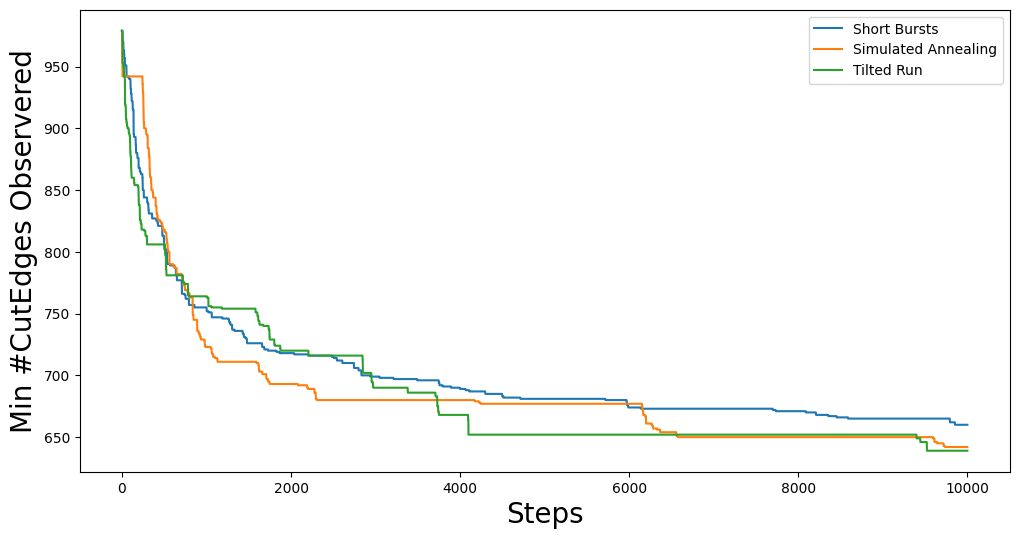

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(min_scores_sb, label="Short Bursts")
plt.plot(min_scores_anneal, label="Simulated Annealing")
plt.plot(min_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Min #CutEdges Observered", fontsize=20)
plt.legend()
plt.show()